In [145]:
import matplotlib.pyplot as plt
import pytesseract
import cv2
import numpy as np
import math
from PIL import Image
EDGE_THRES = 300
custom_config = r'--oem 3 --psm 3'
## Give the input file location
LOC = '../data/inputs/Spring-2020.jpg'
## Name of the output file
NAME = "Spring-2020.ics"
## If you want to the the rotated image change the value to True
rot = False

# Hough Transform

In [3]:
def multiply_kernel(kernel,image):
    if(np.shape(kernel) != np.shape(image)): return image
    a,b = np.shape(kernel)
    kernel = kernel.reshape(a*b)
    image = image.reshape(a*b)

    output = np.dot(kernel,image)
    
    kernel = kernel.reshape(a,b)
    image = image.reshape(a,b)
    return output             

In [4]:
def edge_detection(image,thres):
    ## 3*3 Sobel kernels
    kernelx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    kernely = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    img = image.copy()
    [x,y] = np.shape(img)
    G_x = np.zeros(np.shape(img))
    G_y = np.zeros(np.shape(img))
    output = np.zeros(np.shape(img))
    k,k1 = np.shape(kernelx)
    
    img = np.pad(img,math.floor(k/2))
    
    for (i,j),val in np.ndenumerate(G_x):
        G_x[i,j] = multiply_kernel(kernelx,img[i:i+k,j:j+k]) 
        G_y[i,j] = multiply_kernel(kernely,img[i:i+k,j:j+k])
        output[i,j] = math.sqrt(G_x[i,j]**2 + G_y[i,j]**2)
    
    G_x = (np.round(G_x)).astype(int)
    G_y = (np.round(G_y)).astype(int)
    output = (np.round(output)).astype(int)
    where1 = np.where(output >= thres)
    where0 = np.where(output<thres)
    output[where1] = 255
    output[where0] = 0

    return G_x,G_y,output
    

In [5]:
## This function gives the coordinated of the lines detected using hough transform, input of the functions are the angle and the distance 
## of the line from the origin shape of the image
def get_coords(angle,dist,shape):
    coords = []
    
    # j = 0
    if((dist/math.sin(angle)) >=0 and (dist/math.sin(angle))<shape[0]):
        coords.append((int(0),int(dist/math.sin(angle))))
    
    # i = 0
    if((dist/math.cos(angle)) >=0 and (dist/math.cos(angle)<shape[1])):
        coords.append((int(dist/math.cos(angle)),int(0)))
    
    # i = shape[0]
    if(((dist-shape[0]*math.sin(angle))/math.cos(angle)) >=0 and ((dist-shape[0]*math.sin(angle))/math.cos(angle)<shape[1])):
        coords.append((int((dist-shape[0]*math.sin(angle))/math.cos(angle)),int(shape[0])))
    
    # j = shape[1]
    if(((dist-shape[1]*math.cos(angle))/math.sin(angle)) >=0 and ((dist-shape[1]*math.cos(angle))/math.sin(angle)<shape[0])):
        coords.append((int(shape[1]),int((dist-shape[1]*math.cos(angle))/math.sin(angle))))
    
    return list(set(coords))


In [6]:
## This is the standard hough transform algorithm which forms a accumalator matrix.
def hough(image,thres2):
    img = image.copy()
    out = image.copy()
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    size = np.shape(img)

    G_x, G_y,edge = edge_detection(img,thres2)
    length = int(np.ceil(math.sqrt(size[0]**2 + size[1]**2)))
    
    dist = np.linspace(-length,length,length+1)
    len_dist = len(dist)
    ang = np.linspace(0,180,181)
    sin = np.sin(np.deg2rad(ang))
    cos = np.cos(np.deg2rad(ang))
    len_ang = len(ang)
    param = np.zeros((len_dist,len_ang))
    param_sapce = np.zeros(size)
    
    for (i,j),val in np.ndenumerate(edge):
        for k in range(len_ang):
            if(val ==255):
                p = int((j*cos[k] + i*sin[k]))
                param_sapce[i,j] = p
                x = np.where(dist == p)
                param[x,k] = param[x,k] + 1
    
    return param,len_dist,dist

## This functiosn takes innput of the accumalator matrix and then makes the lines on 
## the image based on the different threshold we get in the function
def findlines(image,accum,len_dist,dist,thres):
    size = image.shape
    out = image.copy()
    coordinates = []

    ang = np.linspace(0,180,181)
    len_ang = len(ang)
    for i in range(len_dist):
        for j in range(len_ang):
            if(accum[i,j] >= thres):
                if(dist[i] == 0): continue
                # print(ang[j],dist[i])
                coordinates.append((ang[j],dist[i]))
                coords = get_coords(np.deg2rad(ang[j]),dist[i],size)
                # print(coords)
                if(len(coords)>=2):
                    out = cv2.line(out,coords[1],coords[0],(0,255,0),1)

    
    return out,coordinates


# Functions To align the image and get the box

In [7]:
## This functiosn takes teh accumaltor matrix and the image and finds the angle of rotations and retur the corrected image
def cor_rot(accum,image,location,len_dist,dist):
    x = np.where(dist == 0)
    accum[x[0],:] = 0
    max_val = np.max(accum)
    output,coords = findlines(image,accum,len_dist,dist,max_val)
    angle = coords[0][0] - 90
    temp = Image.open(location)
    rotated = temp.rotate(angle,resample=Image.BICUBIC)
    rotated = rotated.save("../data/inputs/temp/inter.png")
    correct_image = cv2.imread("../data/inputs/temp/inter.png")
    correct_image = cv2.cvtColor(correct_image,cv2.COLOR_BGR2RGB)
    ## this following image croppes the black border from the image 
    where = np.where(correct_image == (255,255,255))
    x1 = np.min(where[0])
    x2 = np.max(where[0])
    y1 = np.min(where[1])
    y2 = np.max(where[1])
    correct_image = correct_image[x1:x2,y1:y2]  
    return correct_image


In [144]:
## This functions takes the corrected image and returns the area of regiosn and the year or tha almanac
## here we take thetop 15 lines in teh image and the cluster teh lines which are close to each other by 5 pixels
## then these lines are used to find the rectangular regions by finding the two lines which have max distances between them

def get_middle_box(image,accum,len_dist,dist):
    flat_accum = accum.flatten()
    flat_accum.sort()
    thres = flat_accum[-15]
    output,coords = findlines(image,accum,len_dist,dist,thres)
    i = 0
    j = 0
    lens = len(coords)
    while j < lens-1:
        if(coords[i+1][1] - coords[i][1] < 5):
            temp1 = (coords[i+1][0]+coords[i][0])/2
            temp2 = (coords[i+1][1]+coords[i][1])/2
            coords.remove(coords[i+1])
            coords.remove(coords[i])
            coords.insert(i,(temp1,temp2))
            j+=1
        else:
            i+=1
            j+=1

    idx = int(coords[0][1])
    idx2 = int(coords[1][1])
    # plt.imshow(image[idx:idx2])
    text = pytesseract.image_to_string(image[idx:idx2], config=custom_config)
    print(text)
    text = str.lower(text)
    sem = ""
    if "monsoon" in text:
        sem = "Monsoon"
    if "spring" in text:
        sem = "Spring"
    year = [int(i) for i in text.split() if i.isdigit()]
    
    temp1 = 0
    max = 0
    for i in range(len(coords) -1):
        temp = coords[i+1][1] - coords[i][1]
        if(temp > max):
            # print(temp,i)
            max = temp
            temp1 = i
    # print(temp1)
    ll = int(coords[temp1][1])
    ul = int(coords[temp1+1][1])

    box = image[ll-5:ul+5].copy()
    return box,sem,year

# Testing

## Input Of The Image

In [9]:
image = Image.open("../data/inputs/M22_almanac.jpg")
angle = 0
rotated = image.rotate(angle,expand=True,resample=Image.BICUBIC)
rotated = rotated.save("../data/inputs/rotated.png")

/tmp/ipykernel_12420/768848323.py:3: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  rotated = image.rotate(angle,expand=True,resample=Image.BICUBIC)


## Correct the rotated image

In [10]:
if(rot == True):
    LOC = "../data/inputs/rotated.png"
    image_rot = cv2.imread(LOC)
    image_rot = cv2.cvtColor(image_rot,cv2.COLOR_BGR2RGB)
    accum_rot,len_dist_rot,dist_rot = hough(image_rot,EDGE_THRES)

corrected_image = cor_rot(accum_rot,image_rot,LOC,len_dist_rot,dist_rot)
plt.figure(figsize=(40,40))
plt.imshow(corrected_image)

## Getting the interested Box

 

IIT, Hyderabad - Almanac — Spring 2020

 



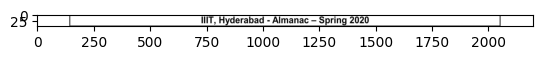

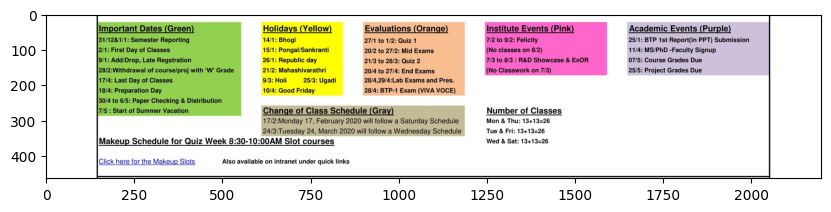

In [142]:
accum,len_dist,dist = hough(corrected_image,EDGE_THRES)
box,sem,year = get_middle_box(corrected_image,accum,len_dist,dist)
plt.figure(figsize=(10,10))
plt.imshow(box)
plt.show()

## Harris Corner Detector

In [70]:
def corner(alma):
    al = np.zeros(alma.shape)
    gray1 = cv2.cvtColor(alma,cv2.COLOR_RGB2GRAY)
    gray1 = np.float32(gray1)


    r, gray1 = cv2.threshold(gray1,150,255,cv2.THRESH_BINARY_INV)
    plt.imshow(gray1)
    kernel = np.ones((3,3),np.uint8)*255
    gray = cv2.erode(gray1,kernel,iterations = 1)  

    plt.imshow(gray)

    dst = cv2.cornerHarris(gray,7,3,0.2)
    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)

    # Threshold for an optimal value, it may vary depending on the image.
    alma[dst>0.3*dst.max()]=[0,0,255]

    al[dst>0.3*dst.max()]=[0,0,255]
    plt.imshow(alma)

    fig = plt.figure(figsize=(30,40))
    plt.imshow(al)
    if cv2.waitKey(0) & 0xff == 27:
        cv2.destroyAllWindows()

# corner(box)

# HAM

In [140]:
def padImage(img, pad):
    H, W = img.shape
    new_img = np.zeros((H+(2*pad),W+(2*pad)), dtype="int")
    new_img[pad:H+pad, pad:W+pad] = img[:, :]

    for i in range(pad):
        new_img[i,:] = new_img[(2*pad) - 1-i]
        new_img[i+pad + H,:] = new_img[H+(pad) - 1-i]
        new_img[:,i] = new_img[:, (2*pad) - 1-i]
        new_img[:, i+pad + W,] = new_img[:, W+(pad) - 1-i]

    return new_img

def HAM(image):
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    tmp,img_bin = cv2.threshold(img,240,255,cv2.THRESH_BINARY)
    # shapes = (piecewiseLinTransform(img, [[0,0,0.0, 0.5], [0,1,0.5,1], [0,1,1,1]]))
    # fig = plt.figure(figsize=(30,40))
    # plt.imshow(img_bin,cmap='gray')

    # img_bin = img_bin[450:690]
    kernel = np.ones((7,7))
    ## apply closing
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel)

    H = img_bin.shape[0]
    W = img_bin.shape[1]

    kernel_size = 7
    pad = kernel_size//2

    kernel1 = np.zeros((kernel_size,kernel_size), dtype=int)
    kernel1[pad:kernel_size, pad:kernel_size] = 255

    kernel2 = np.ones((kernel_size,kernel_size), dtype=int)*255
    kernel2[pad:kernel_size, pad:kernel_size] = 0

    kernel3 = np.ones((kernel_size,kernel_size), dtype=int)*255
    kernel3[pad:kernel_size, 0:pad] = 0

    kernel4 = np.ones((kernel_size,kernel_size), dtype=int)*255
    kernel4[0:pad, pad:kernel_size] = 0

    kernel5 = np.ones((kernel_size,kernel_size), dtype=int)*255
    kernel5[0:pad, 0:pad] = 0

    kernel6 = np.zeros((kernel_size,kernel_size), dtype=int)
    kernel6[0:pad, pad:kernel_size] = 255

    new_img = np.zeros((H+(2*pad), W+(2*pad)), dtype=int)
    new_img[:,:] = padImage(img_bin[:,:], pad)

    # plt.imshow(new_img, cmap='gray')

    coords = []

    for i in range(pad,H+pad):
        for j in range(pad, W+pad):
            # outKernel = np.bitwise_or(kernel, new_img[i-pad:i+pad+1, j-pad:j+pad+1])
            # break
            outKernel = new_img[i-pad:i+pad+1, j-pad:j+pad+1]
            if((outKernel == kernel1).all()):
                coords.append([i,j])
                # fig = plt.figure(figsize=(10,15))
                # plt.imshow(outKernel)
            if((outKernel == kernel2).all()):
                coords.append([i,j])
                # fig = plt.figure(figsize=(10,15))
                # plt.imshow(outKernel)
            
            if((outKernel == kernel3).all()):
                coords.append([i,j])

            if((outKernel == kernel4).all()):
                coords.append([i,j])
            
            if((outKernel == kernel5).all()):
                coords.append([i,j])

            if((outKernel == kernel6).all()):
                coords.append([i,j])
            


    fig = plt.figure(figsize=(30,40))
    # print(coords)

    img = np.zeros((new_img.shape))
    for i in range(len(coords)):
        img[coords[i][0]-1:coords[i][0]+2, coords[i][1]-1: coords[i][1]+2] = 255

    # plt.subplot(121)
    # plt.imshow(new_img, cmap='gray')
    # plt.imshow(new_img[230:, 20:30], cmap="gray")
    # plt.subplot(122)
    # plt.imshow(img, cmap="gray")
    return img_bin


In [72]:
def CCL(img, count):

    H,W = img.shape
    
    trialImg = img.copy().astype(np.uint16)

    id_count = 0
    ids = np.asarray(np.zeros((count,1), dtype="uint"))

    for i in range(H):
        for j in range(W):

            if trialImg[i,j] == 0:
                continue

            if i == 0:
                # top corner pixel
                if j == 0:
                    id_count += 1
                    trialImg[i,j] = id_count

                # left pixel label is copied
                elif trialImg[i,j-1] != 0:
                    trialImg[i,j] = trialImg[i,j-1]
                
                # create new label if left pixel is BG
                else:
                    id_count += 1
                    trialImg[i,j] = id_count
            else:
                top = -1
                left = -1

                # if left pixel exists and is FG, store the value in var 'left'
                if j != 0 and trialImg[i,j-1] != 0:
                    left = trialImg[i,j-1]

                # store the top pixel's value in var 'top' if it is FG
                if trialImg[i-1,j] != 0:
                    top = trialImg[i-1,j]

                # if both were BG, then create new label
                if left == -1 and top == -1:
                    id_count += 1
                    trialImg[i,j] = id_count

                # if even one of them is FG, we check
                else:

                    # if they are equal but FG, assign anyone, doesn't matter
                    if left == top:
                        trialImg[i,j] = top

                    # if unequal but FG, we check in more depth
                    else:

                        # if top doesn't exist but left pixel is FG, assign left pixel label
                        if top == -1 and left != -1:
                            trialImg[i,j] = left
                        
                        # if left doesn't exist but top pixel is FG, assign top pixel label
                        elif top != -1 and left == -1:
                            trialImg[i,j] = top
                        
                        # both have different labels, assign min and record association
                        else:

                            t = ids[top]
                            num1 = top
                            while(t != 0):
                                num1 = t
                                t = ids[t]
                            
                            l = ids[left]
                            num2 = left
                            while(l != 0):
                                num2 = l
                                l = ids[l]
                            
                            minVal = min(num1, num2)
                            trialImg[i,j] = minVal

                            if num1 != num2:
                                if minVal == num1:
                                    ids[num2] = num1
                                else:
                                    ids[num1] = num2
    
    for i in range(id_count+2):
        num = ids[i]
        while(ids[num] != 0):
            num = ids[num]

        ids[i] = num

    rand_colors = np.asarray(np.zeros((count,3), dtype="uint"))

    for k in range(count):
        random_color=list(np.random.choice(range(255),size=3))
        if(random_color == [0,0,0]):
            random_color=list(np.random.choice(range(255),size=3))
        rand_colors[k] = random_color

    outImg1 = np.zeros((H,W,3), dtype="int")
    outImg2 = np.zeros((H,W), dtype="int")

    for i in range(H):
        for j in range(W):
            if trialImg[i,j] != 0 and ids[trialImg[i,j]] != 0:
                trialImg[i,j] = ids[trialImg[i,j]]

            if trialImg[i,j] != 0:
                outImg1[i,j,:] = rand_colors[trialImg[i,j]]
                outImg2[i,j] = trialImg[i,j]

    # print(pixel_each_id)
    return outImg1, outImg2

In [150]:
def get_boxes(img_bin):
    ## Inverting the image 
    copy = np.zeros((img_bin.shape))
    where = np.where(img_bin == 0)
    copy[where] = 255
    ## Applies CCL
    img1,img2 = CCL(copy, 100)
    shape = np.size(img2)
    ## Gets the number of unique objects
    uniq = np.unique(img2)
    for i in uniq:
        where = np.where(img2 == i)
        ar = len(where[0])
        ## Here it rejetcs the small objects which do not contain any text
        if(ar/shape < 0.005):
            img2[where] = 0
            img1[where] = 0

    uniq = np.unique(img2)
    # print(uniq)
    ## Gets the coordinates of the bounding boxes of the unique boxes
    coords = []
    for i in range(1,len(uniq)):
        where = np.where(img2 == uniq[i])
        coords.append([min(where[0]), max(where[0]), min(where[1]), max(where[1])])
    # fig = plt.figure()
    # print(np.unique(img2.flatten()))
    return coords,img2,img1

[ 0  6  7  8  9 10 14]


<Figure size 3000x4000 with 0 Axes>

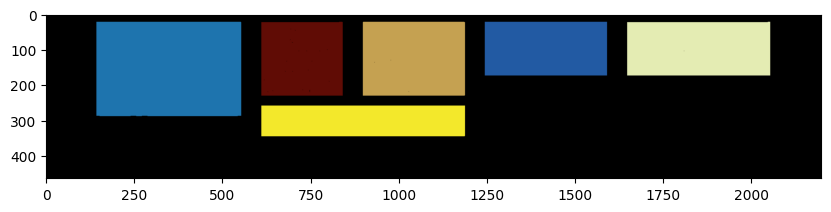

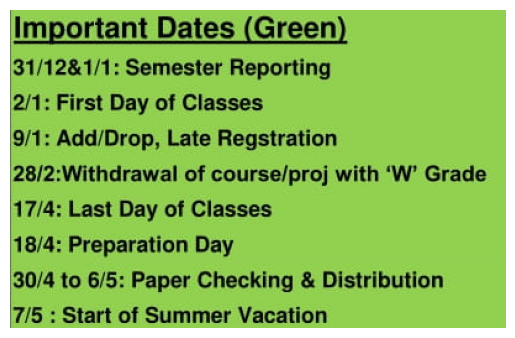

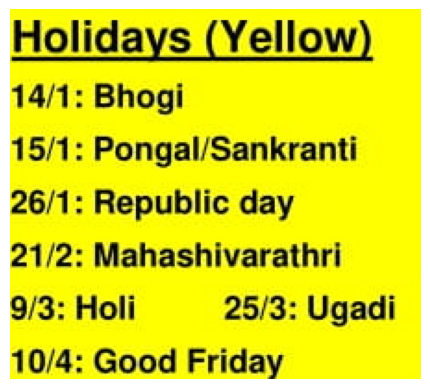

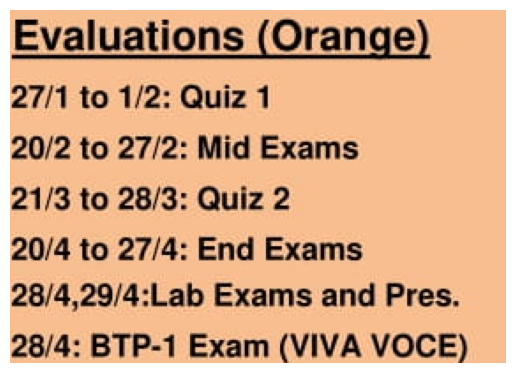

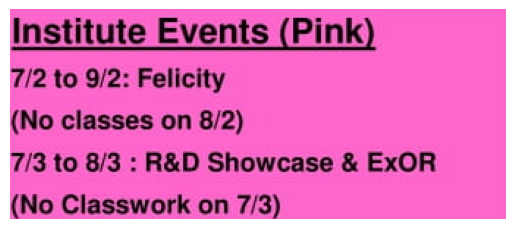

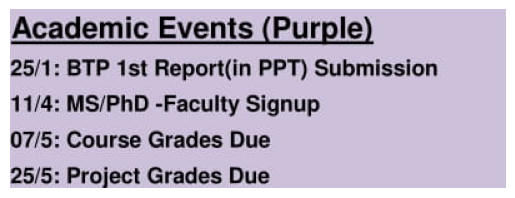

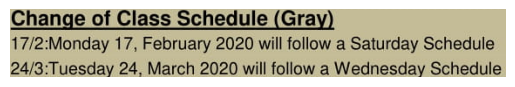

In [149]:
img_bin = HAM(box)
coords,img2,img1 = get_boxes(img_bin)
plt.figure(figsize=(10,10))
plt.imshow(img1)
box_list = []
for i in range(len(coords)):
    # plt.subplot(10,10,i+1)
    fig = plt.figure()
    plt.imshow(box[coords[i][0]+4:coords[i][1]-4, coords[i][2]+4:coords[i][3]-4])
    box_list.append(box[coords[i][0]+4:coords[i][1]-4, coords[i][2]+4:coords[i][3]-4])
    plt.axis('off')
plt.show()

# OCR on Every Box and add it to ics file

In [138]:
import re
import uuid

def txt2Cal(bDates, year,category):
    boxDates = bDates.copy()
    yr = year[0]
    listMaster = []

    ## splits all input strings based on several delimiters to separate bewteen date numbers and text
    for m in range(len(boxDates)):
        nCount = 0
        li = re.split(r" / | /|/ |/| to | to|to |to| - | -|- |-| : | :|: |:| , | ,|, |,| & | &|& |&| ", boxDates[m])
        ## if number of colons in a single line is 2, two events are present in the same line
        if (boxDates[m].count(":") == 2):
            for i in range(len(li)):
                if (li[i].isnumeric()):
                    nCount += 1
                if (nCount == 3):
                    mID = i
                    listMaster.append(li[0:mID])
                    listMaster.append(li[mID:len(li)])
        else:
            listMaster.append(li)

    ## on the string split (containing only numbers and text), numbers are extracted and based on 
    ## the number of numbers, the date format is identified and the rest of the text is merged 
    for m in range(len(listMaster)):
        nCount, mID, cFlag = 0, 0, 0
        date1, month1, year1 = None, None, None
        date2, month2, year2 = None, None, None
        numCount = 0
        # d2Count = 0
        maxID = None
        strList = ""
        ids = []
        li = listMaster[m]

        # no. of numbers indicating date are counted
        if (li[0].isnumeric()):
            for i in range(len(li)):
                if (li[i].isnumeric()):
                    numCount += 1
                    ids.append(i)
                
                if not((li[i+1].isnumeric())):
                    maxID = i
                    break
        else:
            for i in range(len(li)):
                if (li[i].isnumeric()):
                    numCount += 1
                    ids.append(i)
                    if not(li[i-1].isnumeric()):
                        maxID = i

        # based on no. of numbers obtained, input date format is decided

        # order: date1, month1
        # here date2=date2, month2=month1; year is input year
        if (numCount == 2):
            date1, date2 = int(li[ids[0]]), int(li[ids[0]])
            month1, month2 = int(li[ids[1]]), int(li[ids[1]])
            year1, year2 = yr, yr

        #3 date numbers are given
        elif (numCount == 3):
            if int(li[ids[2]]) > 12:
                # DD/MM/YY format provided; YY converted to YYYY
                if int(li[ids[2]]) < 100:
                    date1, date2 = int(li[ids[0]]), int(li[ids[0]])
                    month1, month2 = int(li[ids[1]]), int(li[ids[1]])
                    year1, year2 = 2000+int(li[ids[2]]), 2000+int(li[ids[2]])
                # DD/MM/YYYY format provided
                else:
                    date1, date2 = int(li[ids[0]]), int(li[ids[0]])
                    month1, month2 = int(li[ids[1]]), int(li[ids[1]])
                    year1, year2 = int(li[ids[2]]), int(li[ids[2]])
            # order: date1, date2, month1
            # here month2=month1; year is input year
            else:
                date1 = int(li[ids[0]])
                date2 = int(li[ids[1]])
                month1, month2 = int(li[ids[2]]), int(li[ids[2]])
                year1, year2 = yr, yr
        
        # order: date1, month1, date2, month2
        # year is input year
        elif (numCount == 4):
            date1, month1 = int(li[ids[0]]), int(li[ids[1]])
            date2, month2 = int(li[ids[2]]), int(li[ids[3]])
            year1, year2 = yr, yr
        
        # order: date1, month1, year1, date2, month2, year2
        elif (numCount == 6):
            if int(li[ids[2]]) < 100:
                date1, month1, year1 = int(li[ids[0]]), int(li[ids[1]]), 2000+int(li[ids[2]])
                date2, month2, year2 = int(li[ids[3]]), int(li[ids[4]]), 2000+int(li[ids[5]])
            else:
                date1, month1, year1 = int(li[ids[0]]), int(li[ids[1]]), int(li[ids[2]])
                date2, month2, year2 = int(li[ids[3]]), int(li[ids[4]]), int(li[ids[5]])
        
        if (maxID != None):
            if (li[0].isnumeric()):
                for n in range(maxID+1, len(li)):
                    strList += li[n]+" "
                    # print(strList)
            elif not(li[0].isnumeric()):
                for n in range(maxID):
                    strList += li[n]+" "
                    # print(strList)
        
        if (date1 != None) or (date2 != None):
            my_uuid = uuid.uuid4()
            description = strList
            timings_start = "T000000"
            timings_end = "T235900"
            event = ""
            event += "BEGIN:VEVENT\n"
            # event += f"DTSTART;VALUE=DATE:{str(year1)+ str(month1).zfill(2)+str(date1).zfill(2)}\n"
            # event += f"DTEND;VALUE=DATE:{str(year2)+str(month2).zfill(2)+str(date2).zfill(2)}\n"
            event += f"DTSTART;TZID=Asia/Kolkata:{str(year1)+ str(month1).zfill(2)+str(date1).zfill(2)+timings_start}\n"
            event += f"DTEND;TZID=Asia/Kolkata:{str(year2)+ str(month2).zfill(2)+str(date2).zfill(2)+timings_end}\n"
            event += f"UID:{str(my_uuid)}\n"
            event += f"CATEGORIES:{category}\n"
            event += f"DESCRIPTION: {description}\n"
            event += f"SUMMARY: {description}\n"
            event += "END:VEVENT\n"
            # print(event)
            f.write(event)

    return

In [139]:
f = open("../data/outs/" + NAME, "w")

start_calendar = "BEGIN:VCALENDAR\nPRODID:-//Team Not Devoid//EN\nVERSION:2.0\nCALSCALE:GREGORIAN\nMETHOD:PUBLISH\nX-WR-CALNAME:IIIT Almanac\nX-WR-TIMEZONE:Asia/Kolkata\n"

time_zone_initial = "BEGIN:VTIMEZONE\nTZID:Asia/Kolkata\nX-LIC-LOCATION:Asia/Kolkata\nBEGIN:STANDARD\nTZOFFSETFROM:+0530\nTZOFFSETTO:+0530\nTZNAME:IST\nDTSTART:19700101T000000\nEND:STANDARD\nEND:VTIMEZONE\n"

f.write(start_calendar)
f.write(time_zone_initial)

cat = ["Green category","Yellow category","Orange category","Red category","Blue category","Purple category"]
for i in range(len(box_list)):
    if (pytesseract.image_to_string(box_list[i],config=r'--oem 3 --psm 3') == '\x0c'):
        out = (pytesseract.image_to_string(box_list[i],config=r'--oem 3 --psm 6'))
    else:
        out = pytesseract.image_to_string(box_list[i], config=custom_config)
    
    out = out.split("\n")
    # print(out)
    txt2Cal(out, year, cat[i])

f.write("END:VCALENDAR")
f.close()